In [242]:
import warnings
warnings.filterwarnings("ignore")

In [243]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [244]:
df = pd.read_csv('/datasets/games.csv')

In [245]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [246]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


### Data Preprocessing

Make columns lowercase.

I will use the lower() method on the strings of columns

In [247]:
df.columns = df.columns.str.lower()
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Convert data types:

I will convert the `year_of_release` to datetime, to allow for time analysis in the years.

In [248]:
df.year_of_release.dtype

dtype('float64')

In [249]:
df.year_of_release = pd.to_datetime(df.year_of_release, format='%Y')

I will change the `user_score` to float, because it has ratings of float data types.

In [250]:
df.user_score.dtype

dtype('O')

In [251]:
df.user_score.value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.9       2
0.6       2
0.2       2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [252]:
df.query('user_score == "tbd"').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010-01-01,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005-01-01,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011-01-01,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010-01-01,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
657,Frogger's Adventures: Temple of the Frog,GBA,NaT,Adventure,2.15,0.18,0.0,0.07,73.0,tbd,E


But first I will change the "tbd" values to the average of the maximum user score rating(10), because at average the user does not explicitly decide whether it was a good or bad game.

In [253]:
df.loc[df['user_score'] == 'tbd', 'user_score'] = 5

In [254]:
df['user_score'] = df['user_score'].astype('float')

In [255]:
#missing values

Filling in missing values

In [256]:
df.isnull().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

`name` column has two missing values

In [257]:
df[df['name'].isnull()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993-01-01,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993-01-01,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [258]:
df[df['name'] == 'Game']

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating


Looking at the missing names, it seems that it is the same game recorded twice with separate records for `jp_sales`.
I will fill in with an imaginary name.

In [259]:
df['name'].fillna(value='Game', inplace=True)

In [260]:
#df.loc[df['name'] == 'Game']['jp_sales']

`genre` has two missing values.

I will fill in as Miscelleanous since it can not be determined exactly what genre they belong to.

In [261]:
df.loc[df['genre'].isnull(), 'genre'] = 'Misc'

`year_of_release` has 269 randomly missing values.

The values could be missing because of lack of entry during data collection, or a program error during retrieval form the database.

I will forward-fill in randomly using the fillna() method.

In [262]:
#df[df['year_of_release'].isnull()]

In [263]:
df['year_of_release'].fillna(method='ffill', inplace=True)

`critic_score` and `user_score` have missing values that could be caused at the collection point whereby a user/critic did not provide this data.

I will fill in with -1, to show that this data was not provided.

In [264]:
df['user_score'].fillna(value=-1, inplace=True)

In [265]:
df['critic_score'].fillna(value=-1, inplace=True)

In the `rating`column, I will fill the missing values with 'None' to show that they did not exist.

In [266]:
df['rating'].fillna(value='None', inplace=True)

In [267]:
df.duplicated().sum()

0

#### Calculations:

- Total sales for each game
    - I will add the na, eu, jp and other sales columns

In [268]:
df['total_sales'] = df['eu_sales'] + df['na_sales'] + df['jp_sales'] + df['other_sales']

In [269]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985-01-01,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,None,40.24
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,None,31.38
5,Tetris,GB,1989-01-01,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,None,30.26
6,New Super Mario Bros.,DS,2006-01-01,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006-01-01,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009-01-01,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984-01-01,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,None,28.31


### Data Analysis

1. How many games were released in different years?

In [270]:
year_games = df.pivot_table(index='year_of_release', values='name', aggfunc=['count'])
year_games.columns = ['game_counts']
year_games

,game_counts
year_of_release,
1980-01-01,9
1981-01-01,47
1982-01-01,37
1983-01-01,17
1984-01-01,14
1985-01-01,14
1986-01-01,21
1987-01-01,16
1988-01-01,15


In [271]:
year_games.max(), year_games.min()

(game_counts    1449
 dtype: int64,
 game_counts    9
 dtype: int64)

#### The data for every year is not signififcant since the minimum games released are only 9, while the maximum are 1449. This a very large range.

2. How sales varied form platform to platform.

    - platforms with the greatest total sales
        - groupby platforms and year, sum total sales
        - a distribution on data for each year
    - find platforms that have reduced to zero sales
    - how long does it take for new platforms to appear and old ones to fade?

In [272]:
platform_sales= df.pivot_table(index=['platform'], values='total_sales', aggfunc='sum')

In [273]:
platform_sales.describe()

,total_sales
count,31.000000
mean,287.603548
std,348.160256
min,0.030000
25%,23.360000
50%,200.040000
75%,304.095000
max,1255.770000


I will choose the platforms with the greatest total sales to be one with sales above the 75th percentile, which is 305million.

In [274]:
platform_greatest = platform_sales.query('total_sales > 305')

In [275]:
platform_greatest

,total_sales
platform,
DS,806.12
GBA,317.85
PS,730.86
PS2,1255.77
PS3,939.65
PS4,314.14
Wii,907.51
X360,971.42


In [276]:
df_greatest = df.query('platform in @platform_greatest.index')

In [277]:
greatest_yearly = df_greatest.pivot_table(index=['year_of_release'], values='total_sales', aggfunc='sum')

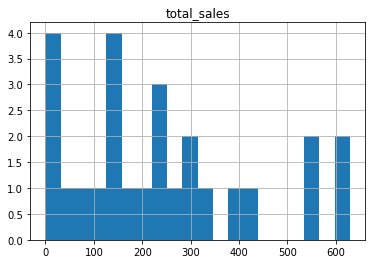

In [278]:
greatest_yearly.hist(bins=20);

Two years in the data set contribute to the highest sales of above 600million.

In [279]:
zero_sales = df.query('year_of_release >= 2015 and total_sales < 0.5')
zero_sales = zero_sales[['platform', 'total_sales']]

In [280]:
zero_sales.query('platform in @platform_greatest.index').groupby('platform')['total_sales'].sum()

platform
DS       0.17
GBA      0.19
PS2      0.19
PS3     10.58
PS4     29.33
Wii      0.59
X360     6.21
Name: total_sales, dtype: float64

I will select the above platforms with zero sales in the last two years, and create scatter plots.

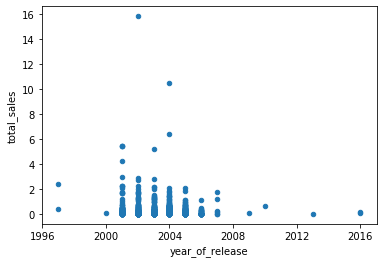

In [281]:
df_GBA = df.query('platform == "GBA"')
df_GBA.plot(kind='scatter', x='year_of_release', y='total_sales' );

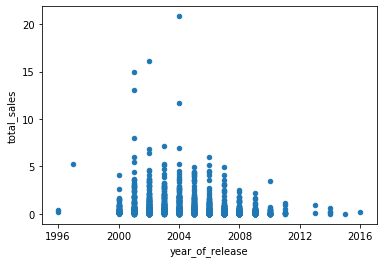

In [282]:
df_PS2 = df.query('platform == "PS2"')
df_PS2.plot(kind='scatter', x='year_of_release', y='total_sales');

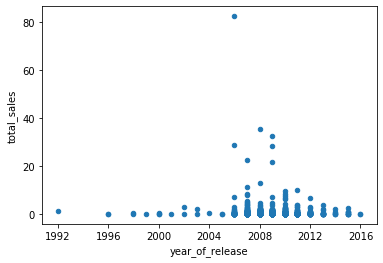

In [283]:
df_Wii = df.query('platform == "Wii"')
df_Wii.plot(kind='scatter', x='year_of_release', y='total_sales');

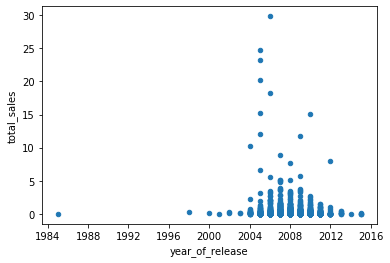

In [284]:
df_DS = df.query('platform == "DS"')
df_DS.plot(kind='scatter', x='year_of_release', y='total_sales');

It  generally took 8 years for new platforms to appear and old ones to fade.

3. What period you should take data for?

I will take data from the period of 2000 to 2016. This is because platforms had yearly total sales of above 350million. This is above the 75th percentile, and is significant data to use to build a prognosis for 2017.

In [285]:
data = df.query('year_of_release >= 2000')

In [286]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14712 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   name             14712 non-null  object        
 1   platform         14712 non-null  object        
 2   year_of_release  14712 non-null  datetime64[ns]
 3   genre            14712 non-null  object        
 4   na_sales         14712 non-null  float64       
 5   eu_sales         14712 non-null  float64       
 6   jp_sales         14712 non-null  float64       
 7   other_sales      14712 non-null  float64       
 8   critic_score     14712 non-null  float64       
 9   user_score       14712 non-null  float64       
 10  rating           14712 non-null  object        
 11  total_sales      14712 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 1.5+ MB


4. Which platforms are leading in sales?

    - Which ones are growing or shrinking?
        - Several potentially profitable platforms

In [287]:
high_sales = (data
              .pivot_table(index='platform', values='total_sales', aggfunc='sum')
              .sort_values(by='total_sales', ascending=False)
             )

In [288]:
high_sales

,total_sales
platform,
PS2,1249.97
X360,968.58
PS3,939.65
Wii,905.62
DS,805.77
GBA,315.08
PS4,314.14
PSP,294.05
3DS,258.93


In [289]:
top5_sales = list(high_sales.head().index)

In [290]:
print('These platforms are leading in sales:{}'.format(top5_sales))

These platforms are leading in sales:['PS2', 'X360', 'PS3', 'Wii', 'DS']


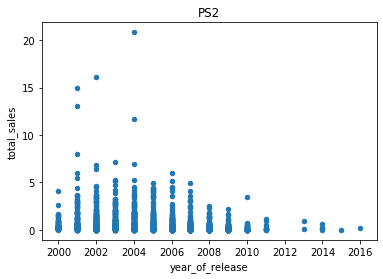

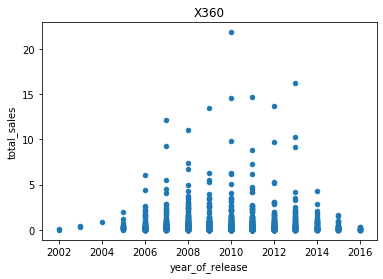

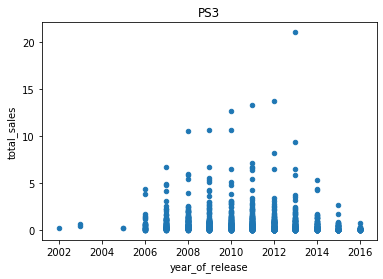

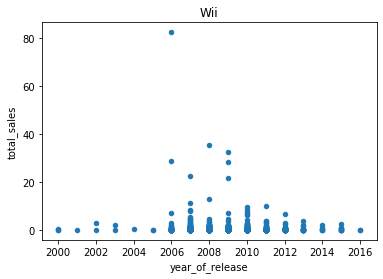

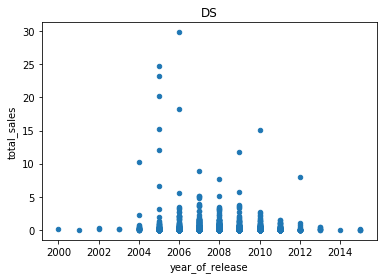

In [291]:
for i in top5_sales:
    df_top5 = data.query('platform == @i')
    df_top5.plot(kind='scatter', x='year_of_release', y='total_sales', title=i)

#### PS3 and X360 are potentially profitable platforms since they are right-skewed. The peak of their highest sales is closer to 2016, than for Wii, DS and PS2.

5. Boxplot for sales by platform
    - are differences in sales significant?
    - average sales significant?
        - describe findings

In [292]:
platform_sales = data.pivot_table(index='platform', values='total_sales', aggfunc=['sum', 'mean'])
platform_sales.columns = ['total_sales', 'avg_sales']
platform_sales.sort_values('total_sales', ascending=True)

,total_sales,avg_sales
platform,,
WS,0.96,0.240000
DC,7.41,0.239032
2600,9.88,0.658667
GB,30.03,1.072500
N64,37.50,0.528169
PSV,54.07,0.125744
WiiU,82.19,0.559116
PS,143.82,0.513643
XOne,159.32,0.645020


In [293]:
platform_sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21 entries, 2600 to XOne
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   total_sales  21 non-null     float64
 1   avg_sales    21 non-null     float64
dtypes: float64(2)
memory usage: 504.0+ bytes


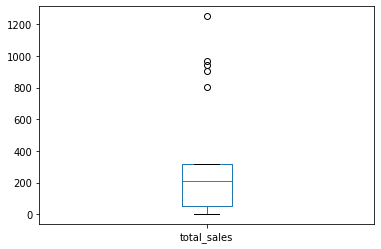

In [294]:
platform_sales['total_sales'].plot(kind='box');

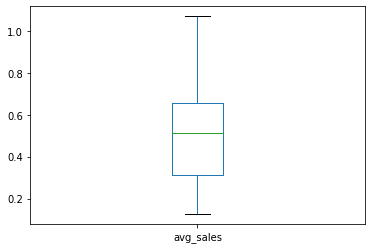

In [295]:
platform_sales['avg_sales'].plot(kind='box');

In [296]:
platform_sales.total_sales.describe(), platform_sales.avg_sales.describe()

(count      21.000000
 mean      344.818571
 std       381.746724
 min         0.960000
 25%        54.070000
 50%       209.370000
 75%       315.080000
 max      1249.970000
 Name: total_sales, dtype: float64,
 count    21.000000
 mean      0.501128
 std       0.237675
 min       0.125744
 25%       0.311338
 50%       0.513643
 75%       0.658667
 max       1.072500
 Name: avg_sales, dtype: float64)

**Yes, the differences in sales are significant. The standard deviation of the total sales is very high which means that each value varies greatly from the mean.**
**The boxplot also shows that there are some outliers in the total sales.**

**Average sales on various platforms do not significantly vary, because of a very low standard deviation, and the mean and median are equal.**
**The box plot shows no outliers.**

6. How user and professional reviews affect sales for one popular platform.
    - build a scatter plot
    - Calculate correlation between reviews and sales
    - draw conclusions

*I will choose the PS3 platform*

In [297]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006-01-01,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006-01-01,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [298]:
ps3_data = data.query('platform == "PS3"')

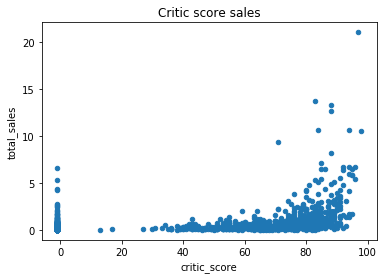

In [299]:
ps3_data.plot(kind='scatter', x='critic_score', y='total_sales', title='Critic score sales');

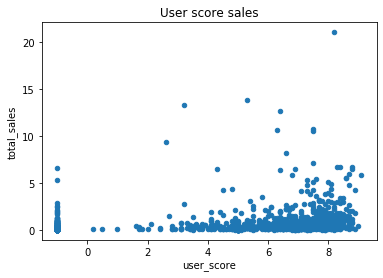

In [300]:
ps3_data.plot(kind='scatter', x='user_score', y='total_sales', title='User score sales');

In [301]:
ps3_data['critic_score'].corr(ps3_data['total_sales'])

0.35379329259319303

In [302]:
ps3_data['user_score'].corr(ps3_data['total_sales'])

0.2449023960868349

In [303]:
ps3_data['user_score'].corr(ps3_data['critic_score'])

0.8067808895436598

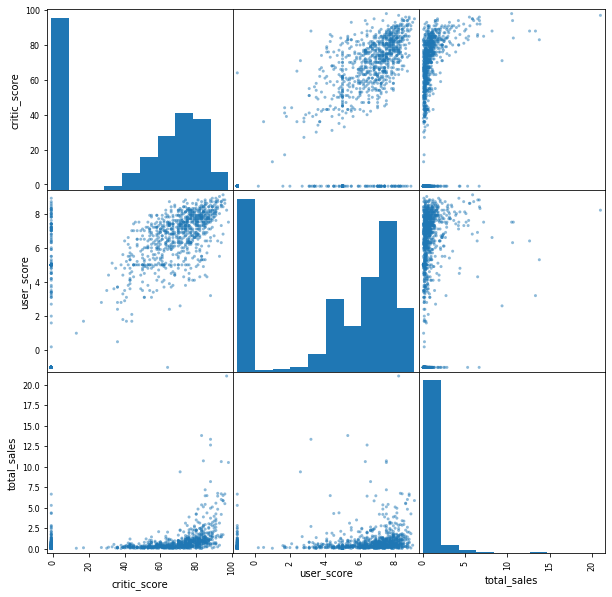

In [304]:
pd.plotting.scatter_matrix(ps3_data[['critic_score', 'user_score', 'total_sales']], figsize=(10,10));

### Conclusion:

**In the PS3 platform;
On the scatter plots, the highest critic scores, from 80-100, translates to high amounts of total sales. 
Whereas the highest user scores, from 8-10, do not give high sales. User scores above average, from 6-8 have higher sales. 
A significant amount of sales are seen when the PS3 games are not scored.**

**Generally, there is a weak but positive correlation between the scores and the total sales.
Critic scores have a stronger linear relation to total sales, than user scores.**

**There is also a strong positive linear correlation between the critic scores and the user scores. For every high critic score, there is a high user score. And vice-versa.**

7. Compare  the sales of games on other platforms.
    - *I will choose:*
         - *PS2, the predecessor of PS3.*
         - *X360, another high sales platform.*
         - *WS, the least popular platform in sales.*

In [305]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006-01-01,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006-01-01,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [306]:
ps2_data = data.query('platform == "PS2"')

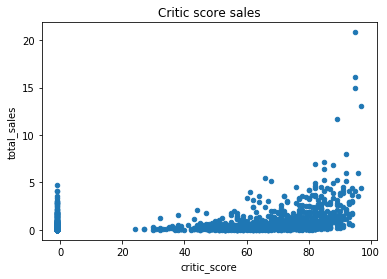

In [307]:
ps2_data.plot(kind='scatter', x='critic_score', y='total_sales', title='Critic score sales');

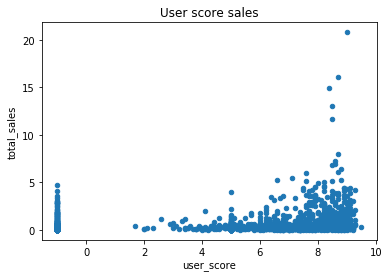

In [308]:
ps2_data.plot(kind='scatter', x='user_score', y='total_sales', title='User score sales');

In [309]:
ps2_data['critic_score'].corr(ps2_data['total_sales'])

0.2980858038333419

In [310]:
ps2_data['user_score'].corr(ps2_data['total_sales'])

0.23601767167296642

In [311]:
ps2_data['user_score'].corr(ps2_data['critic_score'])

0.8526946168109846

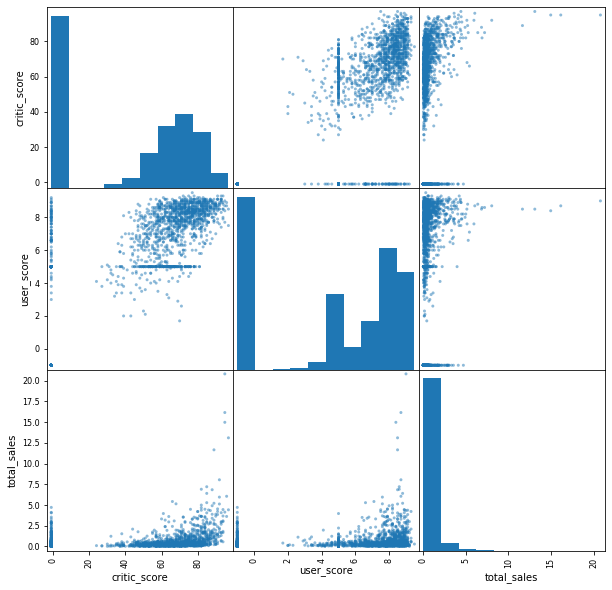

In [312]:
pd.plotting.scatter_matrix(ps2_data[['critic_score', 'user_score', 'total_sales']], figsize=(10,10));

### Conclusion:

**In the PS2 platform;
On the scatter plots, the highest critic scores, from 80-100, translates to high amounts of total sales. 
Whereas the highest user scores, from 8-10, also have high sales. 
A significant amount of sales are seen when the PS2 games are not scored.**

**Generally, there is a weak but positive correlation between the scores and the total sales.
Critic scores and user scores have a strong, equal linear relation to total sales.**

**There is also a strong positive linear correlation between the critic scores and the user scores. For every high critic score, there is a high user score. And vice-versa.**

In [313]:
x360_data = data.query('platform == "X360"')

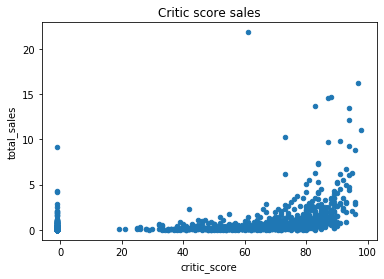

In [314]:
x360_data.plot(kind='scatter', x='critic_score', y='total_sales', title='Critic score sales');

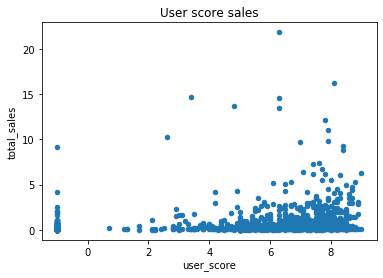

In [315]:
x360_data.plot(kind='scatter', x='user_score', y='total_sales', title='User score sales');

In [316]:
x360_data['critic_score'].corr(x360_data['total_sales'])

0.3109281157595597

In [317]:
x360_data['user_score'].corr(x360_data['total_sales'])

0.18308264598861163

In [318]:
x360_data['critic_score'].corr(x360_data['user_score'])

0.770872441924865

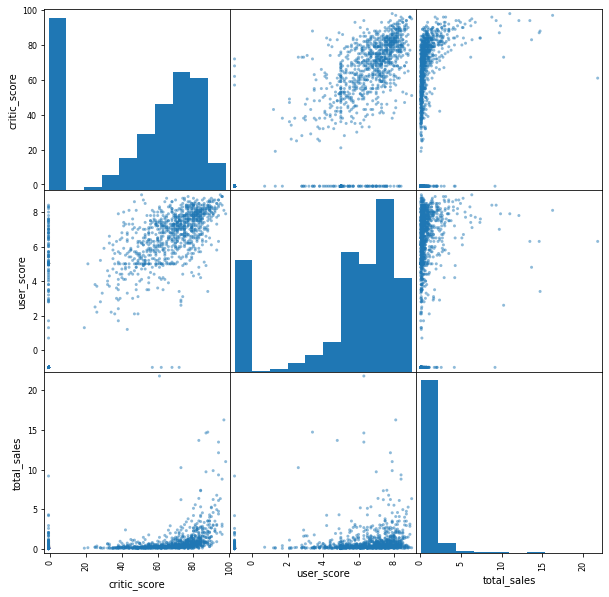

In [319]:
pd.plotting.scatter_matrix(x360_data[['critic_score', 'user_score', 'total_sales']], figsize=(10,10));

### Conclusion:

**In the X360 platform;
On the scatter plots, the highest critic scores, from 80-100, translates to high amounts of total sales. 
Whereas the user scores above average, from 7-9, have high sales. 
A significant amount of sales are seen when the PS2 games are not scored.**

**Generally, there is a weak but positive correlation between the scores and the total sales.
Critic scores have a stronger linear relation to total sales, than user scores.**

**There is also a strong positive linear correlation between the critic scores and the user scores. For every high critic score, there is a high user score. And vice-versa.**

Look at a least popular platform: WS.

In [320]:
ws_data = data.query('platform == "WS"')

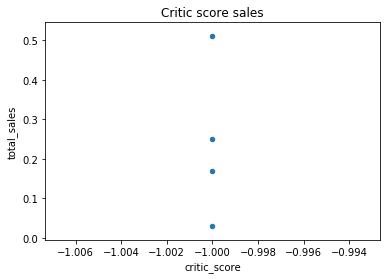

In [321]:
ws_data.plot(kind='scatter', x='critic_score', y='total_sales', title='Critic score sales');

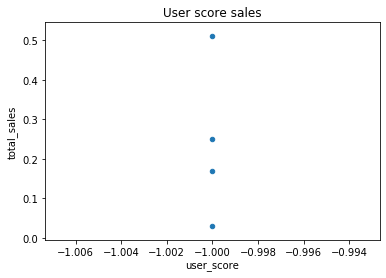

In [322]:
ws_data.plot(kind='scatter', x='user_score', y='total_sales', title='User score sales');

In [323]:
ws_data['critic_score'].corr(ws_data['total_sales'])

nan

In [324]:
ws_data['user_score'].corr(ws_data['total_sales'])

nan

In [325]:
ws_data['critic_score'].corr(ws_data['user_score'])

nan

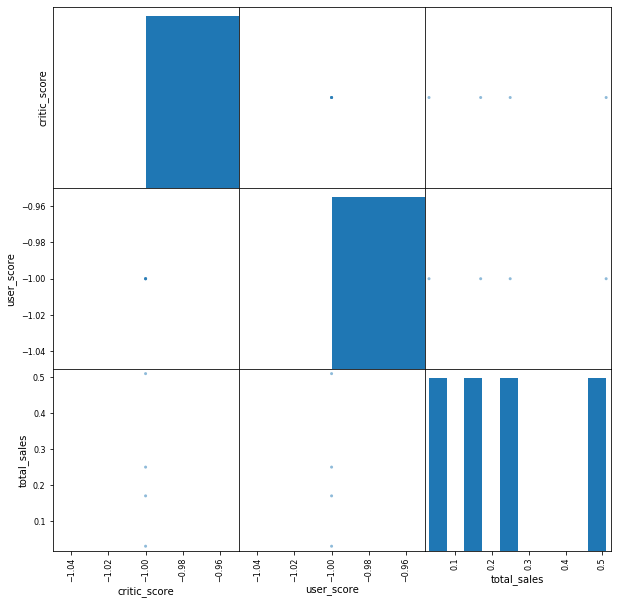

In [326]:
pd.plotting.scatter_matrix(ws_data[['critic_score', 'user_score', 'total_sales']], figsize=(10,10));

### Conclusion:

**In the WS platform;**

**Most games were not scored by both critics and users.**

**Generally, there is a negligible correlation between the scores and the total sales.
This is true because there were no scores recorded, hence sales did not correlate to scores.**

8. Look at distribution of games by genre
   - genre vs sales
    - Conclude on the most profitable genres   
    - Generalize on genres with high and low sales

In [327]:
genre_data = data[['genre', 'total_sales']]

In [328]:
genre_data = (genre_data
              .pivot_table(index='genre', values='total_sales', aggfunc='sum')
              .sort_values(by='total_sales', ascending=False)
             )

In [329]:
genre_data

,total_sales
genre,
Action,1549.28
Sports,1145.85
Shooter,922.89
Role-Playing,734.37
Misc,730.09
Racing,566.24
Platform,496.59
Simulation,337.03
Fighting,316.13


**The most profitable genres are Action and Sports.**

**Genres with high sales are high activity games, that could be very competitive and exciting, while genres with low sales are low activity games that require calmness and composure.**

## User profile for each region:

### For each region(NA, EU, JP):

   - top 5 platforms
        - variations in their market share between regions

In [330]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006-01-01,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006-01-01,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


I will create variables for total sales by platform, for each region.
Then merge each region into a report, for analysis.

In [331]:
na_plat_data = data[['platform', 'na_sales']]

top5_na_plat = (na_plat_data
                 .pivot_table(index='platform', values='na_sales', aggfunc='sum')
                 .sort_values(by='na_sales', ascending=False)
                 .head()
                )
top5_na_plat.reset_index(inplace=True)

In [332]:
eu_plat_data = data[['platform', 'eu_sales']]

top5_eu_plat = (eu_plat_data
                 .pivot_table(index='platform', values='eu_sales', aggfunc='sum')
                 .sort_values(by='eu_sales', ascending=False)
                 .head()
                )
top5_eu_plat.reset_index(inplace=True)

In [333]:
jp_plat_data = data[['platform', 'jp_sales']]

top5_jp_plat = (jp_plat_data
                 .pivot_table(index='platform', values='jp_sales', aggfunc='sum')
                 .sort_values(by='jp_sales', ascending=False)
                 .head()
                )
top5_jp_plat.reset_index(inplace=True)

In [334]:
top5_na_plat, top5_eu_plat, top5_jp_plat

(  platform  na_sales
 0     X360    600.84
 1      PS2    579.39
 2      Wii    495.70
 3      PS3    393.49
 4       DS    382.11,
   platform  eu_sales
 0      PS2    338.88
 1      PS3    330.29
 2     X360    269.82
 3      Wii    261.68
 4       DS    188.87,
   platform  jp_sales
 0       DS    175.55
 1      PS2    139.02
 2      3DS    100.67
 3      PS3     80.19
 4      PSP     76.78)

In [335]:
top5_plat_report = (top5_na_plat
                    .merge(top5_eu_plat, on='platform', how='outer')
                    .merge(top5_jp_plat, on='platform', how='outer')
                    .head()
                   )
top5_plat_report.fillna(value=0, inplace=True)

In [336]:
top5_plat_report

,platform,na_sales,eu_sales,jp_sales
0,X360,600.84,269.82,0.00
1,PS2,579.39,338.88,139.02
2,Wii,495.70,261.68,0.00
3,PS3,393.49,330.29,80.19
4,DS,382.11,188.87,175.55


In [337]:
regions = list(top5_plat_report.columns[1:])
regions

['na_sales', 'eu_sales', 'jp_sales']

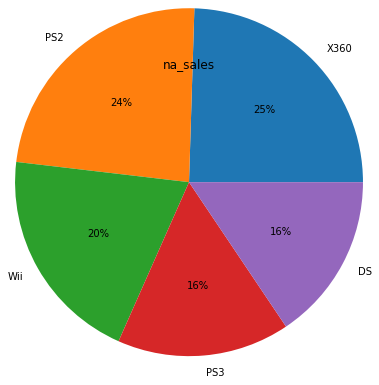

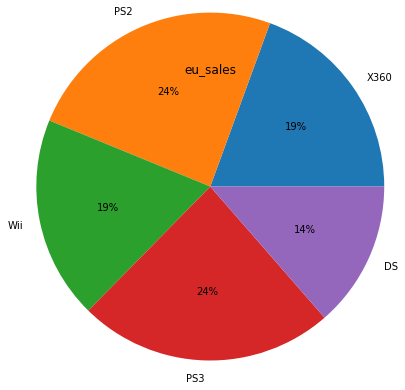

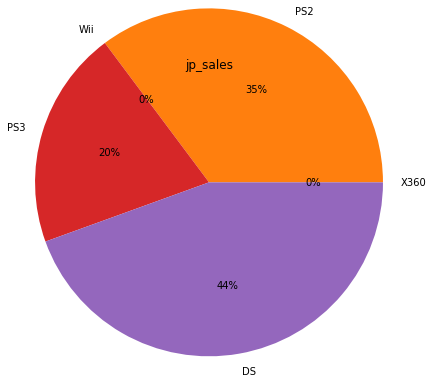

In [338]:
for region in regions:
    values= top5_plat_report[region]
    labels= top5_plat_report['platform']
    plt.axis('equal')
    plt.title(region)
    plt.pie(values, labels=labels, radius=2, autopct='%0.0f%%')
    plt.show();

### Conclusion:

**On market shares for each platform:
In North America, X360 has a 25% market share, followed closely by PS2 and Wii.
PS3 and DS have a market share of less than 20%.**

**In Europe, PS2 and PS3 have a large market share of 24% each, while PS3, DS and Wii have less than 20%.**

**In Japan, DS has a very large market share of 44%, PS2 at 35%, and PS3 at 20%**

**PS2 and PS3 have a presence in all regions.**

**DS has a dominant market share in Japan, whereas in N.AMerica and Europe, it has the least.
X360 has the highest market share in N.America, very little in Europe and No presence in the top5 platforms in Japan.
PS2 has an equal and almost top market share in N.America and Europe of 24%, but in Japan, it has an larger market share of 35% and yet, it's in second place.**

- top 5 genres
     - explain the difference

I will create variables for total sales per genre, for each region.
Then merge each region into a report, for analysis.

In [339]:
na_genre_data = data[['genre', 'na_sales']]

top5_na_genre = (na_genre_data
                 .pivot_table(index='genre', values='na_sales', aggfunc='sum')
                 .sort_values(by='na_sales', ascending=False)
                 .head()
                )
top5_na_genre.reset_index(inplace=True)

In [340]:
eu_genre_data = data[['genre', 'eu_sales']]

top5_eu_genre = (eu_genre_data
                 .pivot_table(index='genre', values='eu_sales', aggfunc='sum')
                 .sort_values(by='eu_sales', ascending=False)
                 .head()
                )
top5_eu_genre.reset_index(inplace=True)

In [341]:
jp_genre_data = data[['genre', 'jp_sales']]

top5_jp_genre = (jp_genre_data
                 .pivot_table(index='genre', values='jp_sales', aggfunc='sum')
                 .sort_values(by='jp_sales', ascending=False)
                 .head()
                )
top5_jp_genre.reset_index(inplace=True)

In [342]:
top5_na_genre, top5_eu_genre, top5_jp_genre

(          genre  na_sales
 0        Action    765.40
 1        Sports    597.48
 2       Shooter    502.11
 3          Misc    372.56
 4  Role-Playing    283.07,
      genre  eu_sales
 0   Action    473.20
 1   Sports    344.35
 2  Shooter    296.56
 3     Misc    198.81
 4   Racing    194.04,
           genre  jp_sales
 0  Role-Playing    243.44
 1        Action    133.52
 2          Misc     86.52
 3        Sports     76.48
 4      Platform     55.39)

In [343]:
top5_genre_report = (top5_na_genre
                    .merge(top5_eu_genre, on='genre', how='outer')
                    .merge(top5_jp_genre, on='genre', how='outer')
                    .head()
                   )
top5_genre_report.fillna(value=0, inplace=True)

In [344]:
top5_genre_report

,genre,na_sales,eu_sales,jp_sales
0,Action,765.40,473.20,133.52
1,Sports,597.48,344.35,76.48
2,Shooter,502.11,296.56,0.00
3,Misc,372.56,198.81,86.52
4,Role-Playing,283.07,0.00,243.44


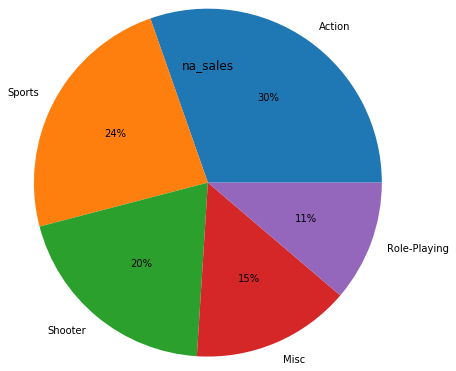

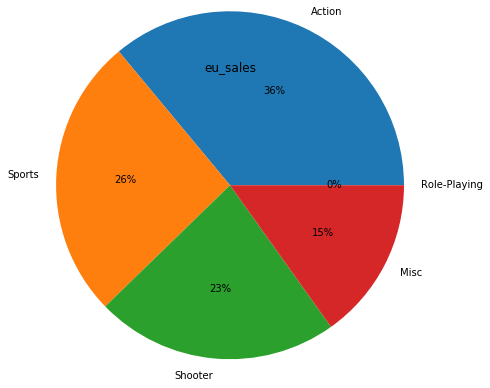

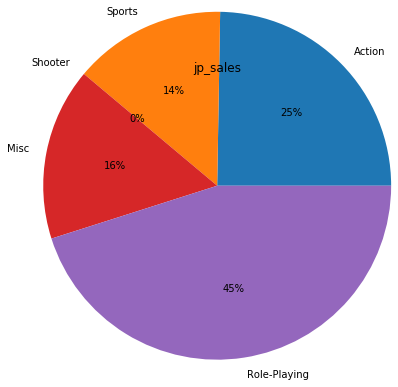

In [345]:
for region in regions:
    values= top5_genre_report[region]
    labels= top5_genre_report['genre']
    plt.axis('equal')
    plt.title(region)
    plt.pie(values, labels=labels, radius=2, autopct='%0.0f%%')
    plt.show();

### Conclusion:

**On market shares for each genre:
In North America, Action has a 30% market share, followed by Sports and Shooter games.
Misc and ROle-playing have a market share of less than 20%.**

**In Europe, Action games have a leading market share of 36%, while Sports and Shooter follow with 26% and 23%, respectively.
Misc has less than 20% of top5 genres market share, while Role-playing has no presence.**

**In Japan, Role-playing has a very large market share of 45%, followed by Action at 25%.
Misc and Sports have less than 20% of top5 genres market share, while Shooter has no presence**

**Role-playing has a dominant market share in Japan, whereas in N.AMerica and Europe, it has the least.
Action has the highest market share in both N.America and Europe, and a fair share in Japan. *Action games sre popular in all three regions.*
Misc has an equal market share in N.America, Europe and Japan of 24%.**

   - do ESRB ratings affect sales in individual regions?

In [346]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006-01-01,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008-01-01,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009-01-01,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006-01-01,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006-01-01,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91


In [347]:
def rate_checker(rates):
    if rates == 'None':
        return False
    else:
        return True

In [348]:
data['has_rating'] = data['rating'].apply(rate_checker)

In [349]:
rating_data = data[['has_rating', 'na_sales', 'eu_sales', 'jp_sales']]

In [350]:
rating_data = rating_data.pivot_table(index='has_rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')

In [351]:
rating_data.reset_index(inplace=True)

In [352]:
rating_data

,has_rating,eu_sales,jp_sales,na_sales
0,False,349.29,401.59,508.29
1,True,1757.81,420.45,3068.47


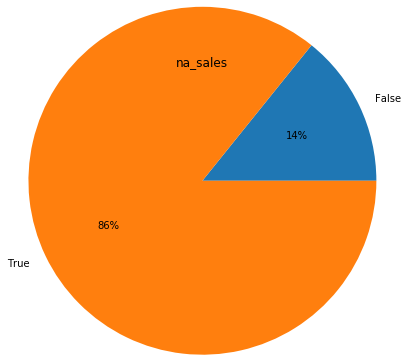

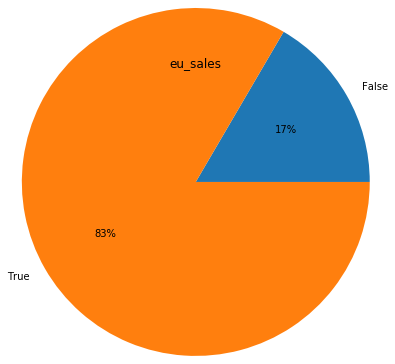

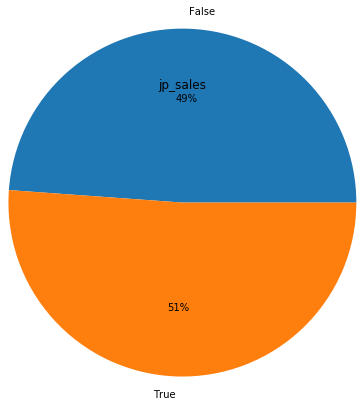

In [353]:
for region in regions:
    values= rating_data[region]
    labels= rating_data['has_rating']
    plt.axis('equal')
    plt.title(region)
    plt.pie(values, labels=labels, radius=2, autopct='%0.0f%%')
    plt.show();

### Conclusion:

**In North America and Europe, games that were rated by ESRB had more than 80% of the market share, while games with no rating had less than 20%.**

**In Japan, rated and non-rated games had an almost equal market share.**

**ESRB ratings affect sales in N.America and Europe, while in Japan, they do not.**

## Test the hypothesis:

1. Average user ratings of the Xbox One and PC platforms are the same.

Null hypotheis: ***The average user ratings of the Xbox One and PC platforms are equal.***

Alternative hypothesis: ***The average user ratings of the Xbox One and PC platforms differ.***

Criterion:
- **I choose to use 5% as the significance level because it is the range within which if the pvalue falls within, then the probablity of the average ratings being equal will be too low, hence the null hypothesis will be rejected. The measured value will be too far from the expected value.**

In [354]:
data['platform'].value_counts()

PS2     2158
DS      2149
PS3     1331
Wii     1314
X360    1256
PSP     1209
PC       933
XB       822
GBA      820
GC       556
3DS      519
PSV      430
PS4      392
PS       280
XOne     247
WiiU     147
N64       71
DC        31
GB        28
2600      15
WS         4
Name: platform, dtype: int64

In [355]:
x1_ratings = data.query('platform == "XOne"')
x1_ratings = x1_ratings[['user_score']]

In [356]:
pc_ratings = data.query('platform == "PC"')
pc_ratings = pc_ratings[['user_score']]

In [365]:
alpha = 0.05
platform_results = st.ttest_ind(x1_ratings, pc_ratings, equal_var=False)

In [366]:
platform_results.pvalue

array([7.87336682e-05])

In [367]:
if platform_results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

We reject the null hypothesis


### Conclusion:

**By  rejecting the null hypothesis, the p-value tells us that the average user ratings in both platforms differs.**

2. Average user ratings for the Action and Sports genres are different.

Null hypotheis: ***The average user ratings for the Action and Sports genres are equal.***

Alternative hypothesis: ***The average user ratings for the Action and Sports genres differ.***

In [360]:
action_ratings = data.query('genre == "Action"')
action_ratings = action_ratings[['user_score']]

In [361]:
sports_ratings = data.query('genre == "Sports"')
sports_ratings = sports_ratings[['user_score']]

In [368]:
genre_results = st.ttest_ind(action_ratings, sports_ratings, equal_var=False)

In [369]:
genre_results.pvalue

array([0.06279114])

In [370]:
if genre_results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We can't reject the null hypothesis")

We can't reject the null hypothesis


### Conclusion:

**By  not rejecting the null hypothesis, the p-value tells us that the average user ratings for Action and Sports are equal.**

# Overall Conclusion:

***To determine whether a game will succeed in North America:*
It should be an Action genre in the X360 or PS2 platforms, with ESRB ratings.**

***To determine whether a game will succeed in Europe:*
It should be an Action genre in the PS2 or PS3 platforms, with ESRB ratings**

***To determine whether a game will succeed in Japan:*
It should be a Role-playing genre in the DS platform, not necessarily with ESRB ratings**

***Generally:* A game of Action genre in the PS2 platform, with ESRB ratings can succeed in both North America and Europe.
North America and Europe have higher margin of sales than Japan.**